CREATE DATABASE BolsaFamilia;

CREATE USER 'overcyber'@'127.0.0.1' IDENTIFIED BY 'a1b2c3d4*';


GRANT ALL PRIVILEGES ON * . * TO 'overcyber'@'127.0.0.1';

GRANT ALL PRIVILEGES ON bf.* TO 'overcyber'@'127.0.0.1' IDENTIFIED BY 'a1b2c3d4*';

FLUSH PRIVILEGES;

In [1]:
# import sqlite3
# import mysql.connector
import os
import glob
import csv
# import pandas as pd
import pandas as pd
import mysql.connector
from mysql.connector import Error
import datetime

In [2]:
def converter_valor_monetario(valor_str):
    return float(valor_str.replace('.', '').replace(',', '.')) if valor_str else 0.0


In [3]:
def converter_data_formato_mysql(data_str):
    try:
        data_formatada = datetime.datetime.strptime(data_str, '%d/%m/%Y').date()
        return data_formatada.strftime('%Y-%m-%d')  # Formato AAAA-MM-DD
    except ValueError:
        return None  # Retorna None se a data não puder ser convertida


In [4]:
 
def processar_e_inserir_arquivos(pasta_raiz, cursor):
    subpastas = glob.glob(os.path.join(pasta_raiz, '2020??_BolsaFamilia_*'))
    
    for subpasta in subpastas:
        tipo = 'Saques' if 'Saques' in subpasta else 'Pagamentos'
        
        arquivos_csv = glob.glob(os.path.join(subpasta, '*.csv'))
        
        for arquivo_csv in arquivos_csv:
            with open(arquivo_csv, 'r', encoding='ISO-8859-1') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=';')
                next(csvreader, None)  # Pula o cabeçalho
                
                for row in csvreader:
                    AnoMesCompetencia, AnoMesReferencia = row[0], row[1]
                    AnoCompetencia, MesCompetencia = int(AnoMesCompetencia[:4]), int(AnoMesCompetencia[4:])
                    AnoReferencia, MesReferencia = int(AnoMesReferencia[:4]), int(AnoMesReferencia[4:])

                    if tipo == 'Saques':
                        (UF, CodigoMunicipioSIAFI, NomeMunicipioSIAFI, CPFBeneficiario, NISBeneficiario, NomeBeneficiario, DataSaque, ValorParcela) = row[2:10]
                        DataSaque = converter_data_formato_mysql(DataSaque)

                        ValorParcela = converter_valor_monetario(ValorParcela)
                        cursor.execute('''
                            INSERT INTO Saques (
                                AnoCompetencia, MesCompetencia, AnoReferencia, MesReferencia, UF, CodigoMunicipioSIAFI, NomeMunicipioSIAFI,
                                CPFBeneficiario, NISBeneficiario, NomeBeneficiario, DataSaque, ValorParcela
                            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                        ''', (AnoCompetencia, MesCompetencia, AnoReferencia, MesReferencia, UF, CodigoMunicipioSIAFI, NomeMunicipioSIAFI,
                            CPFBeneficiario, NISBeneficiario, NomeBeneficiario, DataSaque, ValorParcela))
                    else:
                        (UF, CodigoMunicipioSIAFI, NomeMunicipioSIAFI, CPFBeneficiario, NISBeneficiario, NomeBeneficiario, ValorParcela) = row[2:9]

                        ValorParcela = converter_valor_monetario(ValorParcela)
                        cursor.execute('''
                            INSERT INTO Pagamentos (
                                AnoCompetencia, MesCompetencia, AnoReferencia, MesReferencia, UF, CodigoMunicipioSIAFI, NomeMunicipioSIAFI,
                                CPFBeneficiario, NISBeneficiario, NomeBeneficiario, ValorParcela
                            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                        ''', (AnoCompetencia, MesCompetencia, AnoReferencia, MesReferencia, UF, CodigoMunicipioSIAFI, NomeMunicipioSIAFI,
                            CPFBeneficiario, NISBeneficiario, NomeBeneficiario, ValorParcela))

In [6]:
# Conectar ao banco de dados MySQL remoto
# Função para conectar ao banco de dados
def conectar_banco():
    try:
        conexao = mysql.connector.connect(
            host='127.0.0.1',
            database='bf',
            user='overcyber',
            password='a1b2c3d4*'
        )
        if conexao.is_connected():
            print("conectado")
            return conexao
    except Error as e:
        print("Erro ao conectar ao banco de dados MySQL", e)

# Conectar ao banco de dados MySQL (versão local)
conn = mysql.connector.connect(
    host='127.0.0.1',
    user="overcyber",
    passwd="a1b2c3d4*",
    database="bf"
)
cursor = conn.cursor()


        CREATE TABLE Saques (
            SaqueID INT AUTO_INCREMENT PRIMARY KEY,
            BeneficiarioID INT,
            MunicipioID INT,
            DataSaque DATE,
            ValorParcela DECIMAL(10, 2),
            FOREIGN KEY (BeneficiarioID) REFERENCES Beneficiarios(BeneficiarioID),
            FOREIGN KEY (MunicipioID) REFERENCES Municipios(MunicipioID)
        )
        """,
        """
        CREATE TABLE Pagamentos (
            PagamentoID INT AUTO_INCREMENT PRIMARY KEY,
            BeneficiarioID INT,
            MunicipioID INT,
            ValorParcela DECIMAL(10, 2),
            FOREIGN KEY (BeneficiarioID) REFERENCES Beneficiarios(BeneficiarioID),
            FOREIGN KEY (MunicipioID) REFERENCES Municipios(MunicipioID)
        )


        ADD COLUMN AnoReferencia YEAR,
ADD COLUMN MesReferencia TINYINT,
ADD COLUMN AnoCompetencia YEAR,
ADD COLUMN MesCompetencia TINYINT;

In [7]:
# Função para criar tabelas (ajustada para MySQL)
def criar_tabelas(cursor):
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS Saques (
            SaqueID INT AUTO_INCREMENT PRIMARY KEY,
            AnoCompetencia YEAR,
            MesCompetencia TINYINT,
            AnoReferencia YEAR,
            MesReferencia TINYINT,
            UF VARCHAR(2),
            CodigoMunicipioSIAFI INT,
            NomeMunicipioSIAFI VARCHAR(255),
            CPFBeneficiario VARCHAR(14),
            NISBeneficiario VARCHAR(11),
            NomeBeneficiario VARCHAR(255),
            DataSaque DATE,
            ValorParcela DECIMAL(10, 2)
        )
    ''')
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS Pagamentos (
            PagamentoID INT AUTO_INCREMENT PRIMARY KEY,
            AnoCompetencia YEAR,
            MesCompetencia TINYINT,
            AnoReferencia YEAR,
            MesReferencia TINYINT,
            UF VARCHAR(255),
            CodigoMunicipioSIAFI INT,
            NomeMunicipioSIAFI VARCHAR(255),
            CPFBeneficiario VARCHAR(255),
            NISBeneficiario VARCHAR(255),
            NomeBeneficiario VARCHAR(255),
            ValorParcela DECIMAL(10, 2)
        )
    ''')
    cursor.execute('''
            CREATE TABLE Municipios (
            MunicipioID INT AUTO_INCREMENT PRIMARY KEY,
            CodigoMunicipioSIAFI INT UNIQUE,
            NomeMunicipioSIAFI VARCHAR(255),
            UF VARCHAR(2)
        )
    ''')       
    cursor.execute('''   
        CREATE TABLE Beneficiarios (
            BeneficiarioID INT AUTO_INCREMENT PRIMARY KEY,
            CPFBeneficiario VARCHAR(14) UNIQUE,
            NISBeneficiario VARCHAR(11) UNIQUE,
            NomeBeneficiario VARCHAR(255)
        )
    ''')  

In [8]:
# Criar tabelas
criar_tabelas(cursor)

In [9]:

# Caminho da pasta raiz onde as subpastas estarão localizadas
pasta_raiz = '/Users/over/Mestrado/1A--PPCA-2023/FBD/FBD-BolsaFamilia' 

# Criar tabelas
# criar_tabelas(cursor)

# Chamar a função para processar e inserir os arquivos
processar_e_inserir_arquivos(pasta_raiz, cursor)

# Salvar as alterações e fechar a conexão com o banco de dados
conn.commit()
conn.close()

INSERT INTO Municipios (CodigoMunicipioSIAFI, NomeMunicipioSIAFI, UF)
SELECT DISTINCT CodigoMunicipioSIAFI, NomeMunicipioSIAFI, UF FROM Saques
UNION
SELECT DISTINCT CodigoMunicipioSIAFI, NomeMunicipioSIAFI, UF FROM Pagamentos;


INSERT INTO Beneficiarios (CPFBeneficiario, NISBeneficiario, NomeBeneficiario)
SELECT DISTINCT CPFBeneficiario, NISBeneficiario, NomeBeneficiario FROM Saques
UNION
SELECT DISTINCT CPFBeneficiario, NISBeneficiario, NomeBeneficiario FROM Pagamentos;



ALTER TABLE Saques
ADD COLUMN MunicipioID INT,
ADD COLUMN BeneficiarioID INT,
ADD FOREIGN KEY (MunicipioID) REFERENCES Municipios(MunicipioID),
ADD FOREIGN KEY (BeneficiarioID) REFERENCES Beneficiarios(BeneficiarioID);

ALTER TABLE Pagamentos
ADD COLUMN MunicipioID INT,
ADD COLUMN BeneficiarioID INT,
ADD FOREIGN KEY (MunicipioID) REFERENCES Municipios(MunicipioID),
ADD FOREIGN KEY (BeneficiarioID) REFERENCES Beneficiarios(BeneficiarioID);



UPDATE Saques
SET 
    MunicipioID = (SELECT MunicipioID FROM Municipios WHERE Saques.CodigoMunicipioSIAFI = Municipios.CodigoMunicipioSIAFI),
    BeneficiarioID = (SELECT BeneficiarioID FROM Beneficiarios WHERE Saques.CPFBeneficiario = Beneficiarios.CPFBeneficiario);

UPDATE Pagamentos
SET 
    MunicipioID = (SELECT MunicipioID FROM Municipios WHERE Pagamentos.CodigoMunicipioSIAFI = Municipios.CodigoMunicipioSIAFI),
    BeneficiarioID = (SELECT BeneficiarioID FROM Beneficiarios WHERE Pagamentos.CPFBeneficiario = Beneficiarios.CPFBeneficiario);



ALTER TABLE Saques
DROP COLUMN UF,
DROP COLUMN CodigoMunicipioSIAFI,
DROP COLUMN NomeMunicipioSIAFI,
DROP COLUMN CPFBeneficiario,
DROP COLUMN NISBeneficiario,
DROP COLUMN NomeBeneficiario;

ALTER TABLE Pagamentos
DROP COLUMN UF,
DROP COLUMN CodigoMunicipioSIAFI,
DROP COLUMN NomeMunicipioSIAFI,
DROP COLUMN CPFBeneficiario,
DROP COLUMN NISBeneficiario,
DROP COLUMN NomeBeneficiario;


# ETL - Fase transformação 

removido 

            """
            INSERT IGNORE INTO Beneficiarios (CPFBeneficiario, NISBeneficiario, NomeBeneficiario)
            SELECT DISTINCT CPFBeneficiario, NISBeneficiario, NomeBeneficiario FROM Saques
            WHERE CPFBeneficiario <> ''
            UNION
            SELECT DISTINCT CPFBeneficiario, NISBeneficiario, NomeBeneficiario FROM Pagamentos
            WHERE CPFBeneficiario <> '';
            """,



            ALTER TABLE Saques
            ADD FOREIGN KEY (MunicipioID) REFERENCES Municipios(MunicipioID),
            ADD FOREIGN KEY (BeneficiarioID) REFERENCES Beneficiarios(BeneficiarioID);




            """
            ALTER TABLE Saques
            ADD COLUMN MunicipioID INT,
            ADD COLUMN BeneficiarioID INT,
            ADD FOREIGN KEY (MunicipioID) REFERENCES Municipios(MunicipioID),
            ADD FOREIGN KEY (BeneficiarioID) REFERENCES Beneficiarios(BeneficiarioID);
            """,
            
            """
            ALTER TABLE Pagamentos
            ADD COLUMN MunicipioID INT,
            ADD COLUMN BeneficiarioID INT,
            ADD FOREIGN KEY (MunicipioID) REFERENCES Municipios(MunicipioID),
            ADD FOREIGN KEY (BeneficiarioID) REFERENCES Beneficiarios(BeneficiarioID);
            """,

            """
            INSERT INTO Beneficiarios (CPFBeneficiario, NISBeneficiario, NomeBeneficiario)
            SELECT DISTINCT CPFBeneficiario, NISBeneficiario, NomeBeneficiario FROM Saques
            WHERE CPFBeneficiario <> ''
            UNION
            SELECT DISTINCT CPFBeneficiario, NISBeneficiario, NomeBeneficiario FROM Pagamentos
            WHERE CPFBeneficiario <> '';
            """,
            """
            UPDATE Saques
            SET 
                MunicipioID = (SELECT MunicipioID FROM Municipios WHERE Saques.CodigoMunicipioSIAFI = Municipios.CodigoMunicipioSIAFI),
                BeneficiarioID = (SELECT BeneficiarioID FROM Beneficiarios WHERE Saques.CPFBeneficiario = Beneficiarios.CPFBeneficiario);
            """,
             
            """
            UPDATE Pagamentos
            SET 
                MunicipioID = (SELECT MunicipioID FROM Municipios WHERE Pagamentos.CodigoMunicipioSIAFI = Municipios.CodigoMunicipioSIAFI),
                BeneficiarioID = (SELECT BeneficiarioID FROM Beneficiarios WHERE Pagamentos.CPFBeneficiario = Beneficiarios.CPFBeneficiario);
            """,



#resolver problemas de colunas com dados vazios 


INSERT INTO Beneficiarios (CPFBeneficiario, NISBeneficiario, NomeBeneficiario)
SELECT DISTINCT CPFBeneficiario, NISBeneficiario, NomeBeneficiario FROM Saques
WHERE CPFBeneficiario <> ''
UNION
SELECT DISTINCT CPFBeneficiario, NISBeneficiario, NomeBeneficiario FROM Pagamentos
WHERE CPFBeneficiario <> '';


ou  

INSERT IGNORE INTO Beneficiarios (CPFBeneficiario, NISBeneficiario, NomeBeneficiario)
SELECT DISTINCT CPFBeneficiario, NISBeneficiario, NomeBeneficiario FROM Saques
UNION
SELECT DISTINCT CPFBeneficiario, NISBeneficiario, NomeBeneficiario FROM Pagamentos;


In [17]:
def executar_comandos_sql():
    try:
        # Conectar ao banco de dados
        conexao = mysql.connector.connect(

            host='127.0.0.1',
            user="overcyber",
            passwd="a1b2c3d4*",
            database="bf"
        )
        cursor = conexao.cursor()

        # Comandos SQL para serem executados
        comandos = [

            """
            ALTER TABLE Saques
            DROP COLUMN UF,
            DROP COLUMN CodigoMunicipioSIAFI,
            DROP COLUMN NomeMunicipioSIAFI,
            DROP COLUMN CPFBeneficiario,
            DROP COLUMN NISBeneficiario,
            DROP COLUMN NomeBeneficiario;
            """,
            """
            ALTER TABLE Pagamentos
            DROP COLUMN UF,
            DROP COLUMN CodigoMunicipioSIAFI,
            DROP COLUMN NomeMunicipioSIAFI,
            DROP COLUMN CPFBeneficiario,
            DROP COLUMN NISBeneficiario,
            DROP COLUMN NomeBeneficiario;
            """         
    
        ]

        # Executar cada comando
        for comando in comandos:
            cursor.execute(comando)
            print(f"Comando executado: {comando}")
            conexao.commit()

        print("Comandos executados com sucesso.")
    except mysql.connector.Error as erro:
        print(f"Erro: {erro}")
    finally:
        if conexao.is_connected():
            cursor.close()
            conexao.close()


In [18]:
executar_comandos_sql()


Comando executado: 
            ALTER TABLE Saques
            DROP COLUMN UF,
            DROP COLUMN CodigoMunicipioSIAFI,
            DROP COLUMN NomeMunicipioSIAFI,
            DROP COLUMN CPFBeneficiario,
            DROP COLUMN NISBeneficiario,
            DROP COLUMN NomeBeneficiario;
            
Comando executado: 
            ALTER TABLE Pagamentos
            DROP COLUMN UF,
            DROP COLUMN CodigoMunicipioSIAFI,
            DROP COLUMN NomeMunicipioSIAFI,
            DROP COLUMN CPFBeneficiario,
            DROP COLUMN NISBeneficiario,
            DROP COLUMN NomeBeneficiario;
            
Comandos executados com sucesso.


Erro: 1062 (23000): Duplicate entry '' for key 'beneficiarios.CPFBeneficiario'

# Views 

1. View para Resumo dos Saques por Município
CREATE VIEW ResumoSaquesPorMunicipio AS
SELECT 
    m.NomeMunicipioSIAFI,
    COUNT(s.SaqueID) AS TotalSaques,
    SUM(s.ValorParcela) AS ValorTotalSaques
FROM Saques s
JOIN Municipios m ON s.MunicipioID = m.MunicipioID
GROUP BY m.NomeMunicipioSIAFI;

* Procurar Dados de Saques de um Município Específico
SELECT * FROM ResumoSaquesPorMunicipio
WHERE NomeMunicipioSIAFI = 'GOIANIA';

* Ordenar Municípios pelo Valor Total de Saques
SELECT * FROM ResumoSaquesPorMunicipio
ORDER BY ValorTotalSaques DESC;

* Encontrar Municípios com um Número Mínimo de Saques
SELECT * FROM ResumoSaquesPorMunicipio
WHERE TotalSaques >= NUMERO_MINIMO;

2. View para Detalhes dos Beneficiários e Seus Pagamentos

CREATE VIEW DetalhesBeneficiariosPagamentos AS
SELECT 
    b.BeneficiarioID,
    b.CPFBeneficiario,
    b.NISBeneficiario,
    b.NomeBeneficiario,
    CONCAT_WS('-', p.AnoCompetencia, LPAD(p.MesCompetencia, 2, '0')) AS DataPagamento,
    p.ValorParcela
FROM Beneficiarios b
JOIN Pagamentos p ON b.BeneficiarioID = p.BeneficiarioID;

* Encontrar Pagamentos de um Beneficiário Específico por NIS

SELECT * FROM DetalhesBeneficiariosPagamentos
WHERE NISBeneficiario = '10016033156';


* Buscar Beneficiários com Valor de Pagamento Acima de um Limite Específico

SELECT * FROM DetalhesBeneficiariosPagamentos
WHERE ValorParcela > 100;

* Ordenar Beneficiários pelo Valor da Parcela

SELECT * FROM DetalhesBeneficiariosPagamentos
ORDER BY ValorParcela DESC
LIMIT 100;


3. View para Saques e Pagamentos Recentes


CREATE VIEW SaquesPagamentosRecentes AS
SELECT 
    'Saque' AS TipoTransacao,
    s.DataSaque AS DataTransacao,
    s.ValorParcela
FROM Saques s
WHERE s.DataSaque > '05-01-2020'
UNION ALL
SELECT 
    'Pagamento' AS TipoTransacao,
    CONCAT(p.AnoReferencia, '-', LPAD(p.MesReferencia, 2, '0'), '-01') AS DataTransacao,
    p.ValorParcela
FROM Pagamentos p
WHERE CONCAT(p.AnoReferencia, '-', LPAD(p.MesReferencia, 2, '0'), '-01') > '2023-01-01';

4. View para Resumo de Beneficiario, Sagues e pagamentos
Proporciona um resumo dos saques e pagamentos para cada beneficiário.

CREATE VIEW ResumoBeneficiariosSaquesPagamentos AS
SELECT 
    b.BeneficiarioID,
    b.CPFBeneficiario,
    b.NISBeneficiario,
    b.NomeBeneficiario,
    COUNT(DISTINCT s.SaqueID) AS TotalSaques,
    SUM(s.ValorParcela) AS ValorTotalSaques,
    COUNT(DISTINCT p.PagamentoID) AS TotalPagamentos,
    SUM(p.ValorParcela) AS ValorTotalPagamentos
FROM Beneficiarios b
LEFT JOIN Saques s ON b.BeneficiarioID = s.BeneficiarioID
LEFT JOIN Pagamentos p ON b.BeneficiarioID = p.BeneficiarioID
GROUP BY b.BeneficiarioID, b.CPFBeneficiario, b.NISBeneficiario, b.NomeBeneficiario;


SELECT * FROM ResumoBeneficiariosSaquesPagamentos LIMIT 100 ;

* Procurar por um Beneficiário Específico
SELECT * FROM ResumoBeneficiariosSaquesPagamentos
WHERE NISBeneficiario = '10016033156';

* Filtrar Beneficiários com um Número Mínimo de Saques
SELECT * FROM ResumoBeneficiariosSaquesPagamentos
WHERE TotalSaques >= 20;

* Ordenar Beneficiários pelo Valor Total de Pagamentos
SELECT * FROM ResumoBeneficiariosSaquesPagamentos
ORDER BY ValorTotalPagamentos DESC;

* Buscar Beneficiários de um Município Específico
SELECT v.*
FROM ResumoBeneficiariosSaquesPagamentos v
JOIN Municipios m ON m.BeneficiarioID = v.BeneficiarioID
WHERE m.NomeMunicipioSIAFI = 'GOIANIA';

# Melhores na View ResumoBeneficiariosSaquesPagamentos
1. Criação de Indexes nas Tabelas

CREATE INDEX idx_beneficiario_id ON Saques(BeneficiarioID);
CREATE INDEX idx_beneficiario_id ON Pagamentos(BeneficiarioID);

CREATE INDEX idx_cpf_beneficiario ON Beneficiarios(CPFBeneficiario);
CREATE INDEX idx_nis_beneficiario ON Beneficiarios(NISBeneficiario);
CREATE INDEX idx_nome_beneficiario ON Beneficiarios(NomeBeneficiario);


2. Tabelas Materializadas 
Armazenam os totais pré-calculados de saques e pagamentos por beneficiário, deve ser executado sempre que houver alterações na base, outra ideia e a criação de VIEW Materializadas 

CREATE TABLE ResumoBeneficiarios AS
SELECT 
    b.BeneficiarioID,
    COUNT(DISTINCT s.SaqueID) AS TotalSaques,
    SUM(s.ValorParcela) AS ValorTotalSaques,
    COUNT(DISTINCT p.PagamentoID) AS TotalPagamentos,
    SUM(p.ValorParcela) AS ValorTotalPagamentos
FROM Beneficiarios b
LEFT JOIN Saques s ON b.BeneficiarioID = s.BeneficiarioID
LEFT JOIN Pagamentos p ON b.BeneficiarioID = p.BeneficiarioID
GROUP BY b.BeneficiarioID;




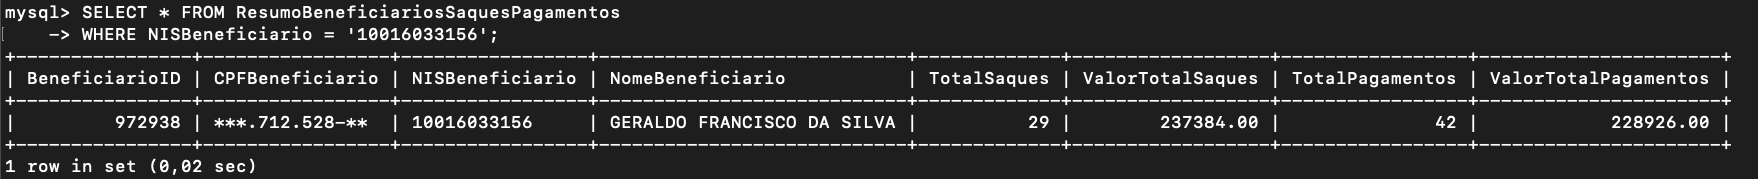 






// SOMENTE TESTE  de View antes de criar o procedure

CREATE VIEW MunicipiosEmGoias AS
SELECT MunicipioID, NomeMunicipioSIAFI, UF
FROM Municipios
WHERE UF = 'GO';

# Consultas teste 

SELECT PagamentoID, BeneficiarioID, AnoCompetencia, MesCompetencia, AnoReferencia, MesReferencia, ValorParcela, MunicipioID FROM Pagamentos LIMIT 100;


SELECT CodigoMunicipioSIAFI, NomeMunicipioSIAFI, UF
FROM Municipios
ORDER BY NomeMunicipioSIAFI
LIMIT 100;

###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### 

5. View com ROLLUP e Materialização

CREATE VIEW ResumoPagamentosPorMunicipioEUF AS
SELECT 
    m.UF,
    m.NomeMunicipioSIAFI,
    SUM(p.ValorParcela) AS ValorTotalPagamentos,
    COUNT(p.PagamentoID) AS NumeroPagamentos
FROM 
    Pagamentos p
JOIN 
    Municipios m ON p.MunicipioID = m.MunicipioID
GROUP BY 
    m.UF, m.NomeMunicipioSIAFI WITH ROLLUP;


* Para acelerar é neessário materialização de VIEW, como o Mysql não suporta foi criado uma tabela regular para simular e criado o codigo SQL para atualização periodica 

1. criação da tabela para armazenar a view

CREATE TABLE ResumoPagamentosPorMunicipioEUF_Mat AS
SELECT 
    m.UF,
    m.NomeMunicipioSIAFI,
    SUM(p.ValorParcela) AS ValorTotalPagamentos,
    COUNT(p.PagamentoID) AS NumeroPagamentos
FROM 
    Pagamentos p
JOIN 
    Municipios m ON p.MunicipioID = m.MunicipioID
GROUP BY 
    m.UF, m.NomeMunicipioSIAFI WITH ROLLUP;

2. Atualização da View materializada simulada, é necessário ( SET GLOBAL event_scheduler = ON; )
DELIMITER //
CREATE EVENT IF NOT EXISTS AtualizarResumoPagamentosPorMunicipioEUF
ON SCHEDULE EVERY 1 DAY
DO
BEGIN
    TRUNCATE TABLE ResumoPagamentosPorMunicipioEUF_Mat;
    INSERT INTO ResumoPagamentosPorMunicipioEUF_Mat
    SELECT 
        m.UF,
        m.NomeMunicipioSIAFI,
        SUM(p.ValorParcela) AS ValorTotalPagamentos,
        COUNT(p.PagamentoID) AS NumeroPagamentos
    FROM 
        Pagamentos p
    JOIN 
        Municipios m ON p.MunicipioID = m.MunicipioID
    GROUP BY 
        m.UF, m.NomeMunicipioSIAFI WITH ROLLUP;
END //
DELIMITER ;









In [20]:
def executar_comandos_sql():
    try:
        # Conectar ao banco de dados
        conexao = mysql.connector.connect(

            host='127.0.0.1',
            user="overcyber",
            passwd="a1b2c3d4*",
            database="bf"
        )
        cursor = conexao.cursor()

        # Comandos SQL para serem executados
        comandos = [
            """
            CREATE VIEW ResumoSaquesPorMunicipio AS
            SELECT 
                m.NomeMunicipioSIAFI,
                COUNT(s.SaqueID) AS TotalSaques,
                SUM(s.ValorParcela) AS ValorTotalSaques
            FROM Saques s
            JOIN Municipios m ON s.MunicipioID = m.MunicipioID
            GROUP BY m.NomeMunicipioSIAFI;
            """,
            
            """
            CREATE VIEW DetalhesBeneficiariosPagamentos AS
            SELECT 
                b.CPFBeneficiario,
                b.NomeBeneficiario,
                CONCAT_WS('-', p.AnoCompetencia, LPAD(p.MesCompetencia, 2, '0')) AS DataPagamento,
                p.ValorParcela
            FROM Beneficiarios b
            JOIN Pagamentos p ON b.BeneficiarioID = p.BeneficiarioID;


            """,
            
            """
            CREATE VIEW SaquesPagamentosRecentes AS
            SELECT 
                'Saque' AS TipoTransacao,
                s.DataSaque AS DataTransacao,
                s.ValorParcela
            FROM Saques s
            WHERE s.DataSaque > '05-01-2020'
            UNION ALL
            SELECT 
                'Pagamento' AS TipoTransacao,
                CONCAT(p.AnoReferencia, '-', LPAD(p.MesReferencia, 2, '0'), '-01') AS DataTransacao,
                p.ValorParcela
            FROM Pagamentos p
            WHERE CONCAT(p.AnoReferencia, '-', LPAD(p.MesReferencia, 2, '0'), '-01') > '05-01-2020';
            """,
            
            """
            CREATE VIEW ResumoBeneficiariosSaquesPagamentosPorNIS AS
            SELECT 
                b.NISBeneficiario,
                b.NomeBeneficiario,
                COUNT(DISTINCT s.SaqueID) AS TotalSaques,
                SUM(s.ValorParcela) AS ValorTotalSaques,
                COUNT(DISTINCT p.PagamentoID) AS TotalPagamentos,
                SUM(p.ValorParcela) AS ValorTotalPagamentos
            FROM Beneficiarios b
            LEFT JOIN Saques s ON b.BeneficiarioID = s.BeneficiarioID
            LEFT JOIN Pagamentos p ON b.BeneficiarioID = p.BeneficiarioID
            GROUP BY b.NISBeneficiario, b.NomeBeneficiario;
            """
        ]

        # Executar cada comando
        for comando in comandos:
            cursor.execute(comando)
            print(f"Comando executado: {comando}")

            conexao.commit()

        print("Comandos executados com sucesso.")
    except mysql.connector.Error as erro:
        print(f"Erro: {erro}")
    finally:
        if conexao.is_connected():
            cursor.close()
            conexao.close()


In [21]:
executar_comandos_sql()

Comando executado: 
            CREATE VIEW ResumoSaquesPorMunicipio AS
            SELECT 
                m.NomeMunicipioSIAFI,
                COUNT(s.SaqueID) AS TotalSaques,
                SUM(s.ValorParcela) AS ValorTotalSaques
            FROM Saques s
            JOIN Municipios m ON s.MunicipioID = m.MunicipioID
            GROUP BY m.NomeMunicipioSIAFI;
            
Erro: 1054 (42S22): Unknown column 'p.DataPagamento' in 'field list'


# Triggers

OBS: FOi necessário alterar o delimitador padrão (;) para // temporariamente para executar a query dos triggers via linha de comando, usando a instrução DELIMITER 


* Trigger para Impedir Atualização de Beneficiários com Valores Repetidos


DELIMITER //

CREATE TRIGGER before_update_beneficiarios
BEFORE UPDATE ON Beneficiarios
FOR EACH ROW
BEGIN
    DECLARE cpf_count INT;
    DECLARE nis_count INT;

    SELECT COUNT(*) INTO cpf_count
    FROM Beneficiarios
    WHERE CPFBeneficiario = NEW.CPFBeneficiario AND BeneficiarioID <> NEW.BeneficiarioID;

    SELECT COUNT(*) INTO nis_count
    FROM Beneficiarios
    WHERE NISBeneficiario = NEW.NISBeneficiario AND BeneficiarioID <> NEW.BeneficiarioID;

    IF cpf_count > 0 OR nis_count > 0 THEN
        SIGNAL SQLSTATE '45000'
        SET MESSAGE_TEXT = 'Não é possível atualizar para um CPF ou NIS já existente em outro registro.';
    END IF;
END; //

DELIMITER ;



* Trigger para Impedir Atualização de Municípios com Valores Repetidos


DELIMITER //

CREATE TRIGGER before_update_municipios
BEFORE UPDATE ON Municipios
FOR EACH ROW
BEGIN
    DECLARE municipio_count INT;

    SELECT COUNT(*) INTO municipio_count
    FROM Municipios
    WHERE CodigoMunicipioSIAFI = NEW.CodigoMunicipioSIAFI AND MunicipioID <> NEW.MunicipioID;

    IF municipio_count > 0 THEN
        SIGNAL SQLSTATE '45000'
        SET MESSAGE_TEXT = 'Não é possível atualizar para um código de município SIAFI já existente em outro registro.';
    END IF;
END; //

DELIMITER ;


# Procedures 


* Listar pagamentos de um Município

DELIMITER //

CREATE PROCEDURE ListarPagamentosPorMunicipio(IN municipioID INT)
BEGIN
    SELECT p.PagamentoID, p.ValorParcela, b.NomeBeneficiario
    FROM Pagamentos p
    JOIN Beneficiarios b ON p.BeneficiarioID = b.BeneficiarioID
    WHERE p.MunicipioID = municipioID;
END; //

DELIMITER ;


CALL ListarPagamentosPorMunicipio(123);


* Procedure para soma total de pagamentos de um Município


DELIMITER //

CREATE PROCEDURE SumarizarPagamentosPorMunicipio(IN municipioID INT)
BEGIN
    SELECT MunicipioID, SUM(ValorParcela) AS TotalPagamentos
    FROM Pagamentos
    WHERE MunicipioID = municipioID
    GROUP BY MunicipioID;
END; //

DELIMITER ;



CALL SumarizarPagamentosPorMunicipio(7401);

* Procedure para soma total de pagamentos de um Município com o nome 

DELIMITER //

CREATE PROCEDURE SumarizarPagamentosPorMunicipioNome(IN municipioID INT)
BEGIN
    SELECT m.NomeMunicipioSIAFI, p.MunicipioID, SUM(p.ValorParcela) AS TotalPagamentos

    FROM Pagamentos p
    JOIN Municipios m ON p.MunicipioID = m.MunicipioID
    WHERE p.MunicipioID = municipioID
    GROUP BY p.MunicipioID, m.NomeMunicipioSIAFI;
END; //

DELIMITER ;

CALL SumarizarPagamentosPorMunicipioNome(1358);





###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### 
* Procedure para Somar Saques por UF

DELIMITER //

CREATE PROCEDURE SomarSaquesPorUF()
BEGIN
    SELECT m.UF, SUM(s.ValorParcela) AS TotalSaques
    FROM saques s
    JOIN Municipios m ON s.MunicipioID = m.MunicipioID
    GROUP BY m.UF;
END //

DELIMITER ;

CALL SomarSaquesPorUF();

###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### 
* Procedure para Somar Pagamentos por UF

DELIMITER //

CREATE PROCEDURE SomarPagamentosPorUF()
BEGIN
    SELECT m.UF, SUM(p.ValorParcela) AS TotalPagamentos
    FROM pagamentos p
    JOIN Municipios m ON p.MunicipioID = m.MunicipioID
    GROUP BY m.UF;
END //

DELIMITER ;

CALL SomarPagamentosPorUF();


###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### 
* Procedure para Somar Pagamentos por UF, ordenado por valor (ascendente) ASC
DELIMITER //

CREATE PROCEDURE SomarPagamentosPorUFValor()
BEGIN
    SELECT m.UF, SUM(p.ValorParcela) AS TotalPagamentos
    FROM pagamentos p
    JOIN Municipios m ON p.MunicipioID = m.MunicipioID
    GROUP BY m.UF
    ORDER BY SUM(p.ValorParcela) ASC;
END //

DELIMITER ;


CALL SomarPagamentosPorUFValor();

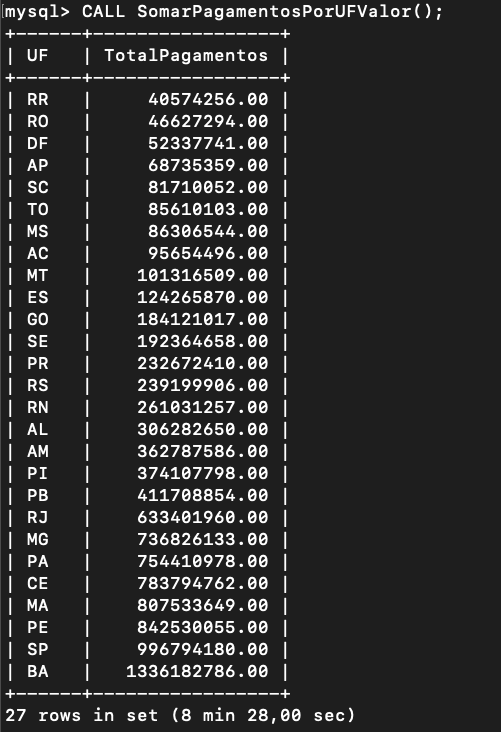


###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### 
* Calcular a Soma de Saques e Pagamentos por UF em um Ano Específico


DELIMITER //

CREATE PROCEDURE SomaPorUFAno(IN anoReferencia YEAR)
BEGIN
    SELECT resultados.UF, resultados.Tipo, resultados.SomaValor
    FROM (
        SELECT m.UF AS UF, 'Saques' AS Tipo, SUM(s.ValorParcela) AS SomaValor
        FROM saques s
        JOIN Municipios m ON s.MunicipioID = m.MunicipioID
        WHERE s.AnoReferencia = anoReferencia
        GROUP BY m.UF

        UNION ALL

        SELECT m.UF AS UF, 'Pagamentos' AS Tipo, SUM(p.ValorParcela) AS SomaValor
        FROM pagamentos p
        JOIN Municipios m ON p.MunicipioID = m.MunicipioID
        WHERE p.AnoReferencia = anoReferencia
        GROUP BY m.UF
    ) AS resultados
    WHERE resultados.SomaValor > 0;
END //

DELIMITER ;


CALL SomaPorUFAno([2019]);


###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### 
* Procedure para soma de saques e pagamentos por UF em um ano específico
DELIMITER //

CREATE PROCEDURE MediaSaquesPorUF()
     BEGIN
        SELECT m.UF, AVG(s.ValorParcela) AS MediaSaques
        FROM saques s
        JOIN Municipios m ON s.MunicipioID = m.MunicipioID
        GROUP BY m.UF;
     END //
DELIMITER ;


###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### 
* Procedure para media de saques por UF organizado por favor (ascendente)


DELIMITER //

CREATE PROCEDURE MediaSaquesPorUF()
    BEGIN
        SELECT m.UF, AVG(s.ValorParcela) AS MediaSaques
        FROM saques s
        JOIN Municipios m ON s.MunicipioID = m.MunicipioID
        GROUP BY m.UF;
     END //

DELIMITER ;

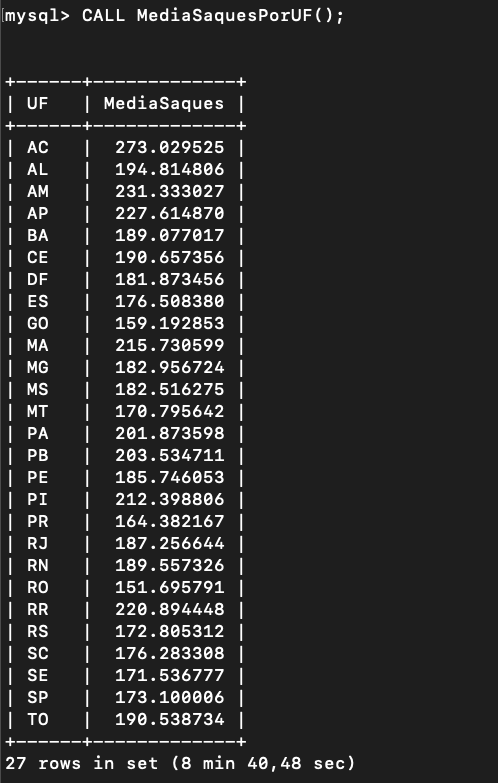

###### ###### #######
DELIMITER //

CREATE PROCEDURE MediaSaquesPorUFValor()
BEGIN
    SELECT m.UF, AVG(s.ValorParcela) AS MediaSaques
    FROM saques s
    JOIN Municipios m ON s.MunicipioID = m.MunicipioID
    GROUP BY m.UF
    HAVING AVG(s.ValorParcela) > 200
    ORDER BY AVG(s.ValorParcela) ASC;
END //

DELIMITER ;

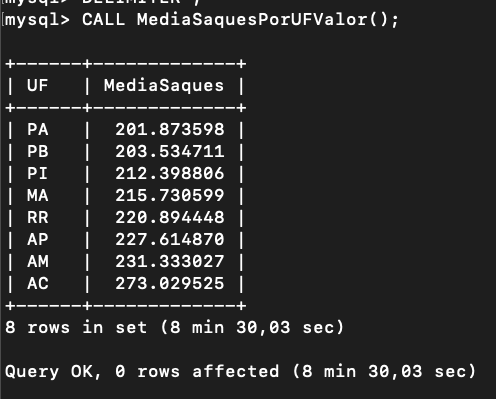




# COM ERROS


###### ###### ###### ###### ###### COM erros  ###### ###### ###### ###### ###### ###### ###### 
* Procedure para filtrar  municipios por estados 


DELIMITER //

CREATE PROCEDURE MunicipiosPorEstado(IN estado CHAR(2))
BEGIN
    SELECT MunicipioID, NomeMunicipioSIAFI, UF
    FROM Municipios
    WHERE UF = estado;
END //

DELIMITER ;

CALL MunicipiosPorEstado('GO');



DELIMITER //

CREATE PROCEDURE SomarPagamentosPorMesReferenciaEstado(IN mesReferencia TINYINT, IN anoReferencia YEAR)
BEGIN
    SELECT 
        m.UF,
        p.AnoReferencia,
        p.MesReferencia,
        p.AnoCompetencia,
        p.MesCompetencia,
        SUM(p.ValorParcela) AS TotalPagamentos
    FROM Pagamentos p
    JOIN Municipios m ON p.MunicipioID = m.MunicipioID
    WHERE p.MesReferencia = mesReferencia AND p.AnoReferencia = anoReferencia
    GROUP BY m.UF, p.AnoReferencia, p.MesReferencia, p.AnoCompetencia, p.MesCompetencia;
END //

DELIMITER ;


CALL SomarPagamentosPorMesReferenciaEstado(5, 2019);


Este procedimento calcula a soma dos pagamentos de cada estado para um mês e ano de referência específicos. O procedimento agrupa os resultados por estado e pelos campos de referência e competência, permitindo ver os pagamentos totais por estado em um determinado mês e ano.


DELIMITER //

CREATE PROCEDURE SomarPagamentosPorMesEAno(IN mesReferencia TINYINT, IN anoReferencia YEAR)
BEGIN
    SELECT 
        m.UF,
        p.AnoReferencia,
        p.MesReferencia,
        p.AnoCompetencia,
        p.MesCompetencia,
        SUM(p.ValorParcela) AS TotalPagamentos
    FROM Pagamentos p
    JOIN Municipios m ON p.MunicipioID = m.MunicipioID
    WHERE p.MesReferencia = mesReferencia AND p.AnoReferencia = anoReferencia
    GROUP BY m.UF, p.AnoReferencia, p.MesReferencia, p.AnoCompetencia, p.MesCompetencia;
END //

DELIMITER ;

CALL SomarPagamentosPorMesEAno(5, 2019);